In [8]:
import numpy as np
import pandas as pd
import tensorflow as tf

from loguru import logger
from matplotlib import pyplot as plt
from keras import Sequential
from keras import optimizers
from keras import metrics
from keras import layers

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, classification_report
from scikeras.wrappers import KerasClassifier

from utils_monk import read_split_data, abs_path

In [9]:
def create_nn(input_shape,
                  hidden_nodes = 16,
                  summary = False,
                  activation = 'relu',
                  eta = 0.002,
                  alpha=0.7,
                  lmb = 0.0001
                  ):
    """
    Create a neural network model using Keras API in order to solve a regression problem.

    :param input_shape: shape of the data given to the input layer of the NN
    :type input_shape: tuple
    :param hidden_layers: optional(default = 3): number of hidden layers in the network
    :type hidden_layers: int
    :param hidden_nodes: optional(default = 32) number of nodes in each hidden layer
    :type hidden_nodes: int
    :param dropout: optional (default = 0.00): dropout rate of dropout layers
    :type dropout: float
    :param summary: optional (default = False): show the summary of the model
    :type summary: bool
    :param activation: optional(default = 'relu') activation function to use
    :type activation: str
    :param eta: optional(default = 0.002) learning rate of the SGD
    :type eta: float
    :param alpha: optional(default = 0.7) momentum of SGD
    :type alpha: float
    :param alpha: optional(default = 0.0001) regularization parameter
    :type alpha: float
    :type init_mode: str
    
    :return: neural network model
    :rtype: Sequential
    """
    model = Sequential()

    # Input layer 
    model.add(layers.Dense(units=hidden_nodes, activation=activation, input_shape=(input_shape,)))

    # Output layer
    model.add(layers.Dense(units=1, activation='sigmoid'))

    # Adding optimizer for the model
    optimizer = optimizers.SGD(learning_rate=eta, momentum=alpha)

    # Compiling the model
    model.compile(optimizer=optimizer, loss = 'mean_squared_error', metrics=['accuracy'])

    # Printing summary, if specified
    if summary:
        logger.info("Model successfully compiled, showing detailed summary ")
        model.summary()
    else: 
        pass
    return model

In [10]:
def model_selection(x, y, n_splits, epochs):
    
    input_shape = np.shape(x)[1]
    
    model = KerasClassifier(model=create_nn, input_shape = input_shape, epochs=epochs, batch_size= 32, verbose=0)

    # Setting the grid search parameters
    eta = [0.05, 0.5]

    alpha = [0.4, 0.6]

    lmb = [0.001, 0.01]

    param_grid = dict(model__eta=eta, model__alpha=alpha, model__lmb=lmb)

    # K-folding definition
    folds = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', refit = 'accuracy',
        cv = folds, n_jobs = 1, return_train_score=True, verbose = 1)

    # Fitting grid search
    logger.info("Starting Grid Search for hyperparameter optimization")
    grid_result = grid.fit(x, y)

    best_params = grid_result.best_params_

    # Summarizing results
    logger.info(f"Best: {grid_result.best_score_} using {best_params}")
    
    return best_params

In [11]:
def predict(model, X_test, y_test):
    """
    Predicts the test values and computes the metrics

    :param model: model used for predictions
    :param X_test: features to classify
    :param y_test: targets
    
    :return: 
    y_pred, predictions on test set
    [test_loss], mean squared error on test set
    [test_accuracy], accuracy on test set
    
    """
    # Prediction
    y_pred = model.predict(X_test)

    # Reshape y_pred per match con y_test
    y_pred = y_pred.flatten()
    
    # Computing the mean_squared_error
    test_loss = mean_squared_error(y_test, y_pred)
    
    return y_pred, test_loss

In [12]:
def plot_learning_curve(history_dic, start_epoch=1, end_epoch=400, savefig=False):

    lgd = ['loss TR']
    plt.plot(range(start_epoch, end_epoch), history_dic['loss'][start_epoch:])
    if "val_loss" in history_dic:
        plt.plot(range(start_epoch, end_epoch), history_dic['val_loss'][start_epoch:])
        lgd.append('loss VL')

    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.yscale('log')
    plt.title(f'Keras learning curve')
    plt.legend(lgd)

    if savefig:
        plt.savefig("plot\keras3_mse", transparent = True)
    plt.show()

    lgd = ['accuracy TR']
    plt.plot(range(start_epoch, end_epoch), history_dic['accuracy'][start_epoch:])
    if "val_accuracy" in history_dic:
        plt.plot(range(start_epoch, end_epoch), history_dic['val_accuracy'][start_epoch:])
        lgd.append('accuracy VL')

    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.yscale('log')
    plt.title(f'Keras learning curve')
    plt.legend(lgd)

    if savefig:
        plt.savefig("plot\keras3_acc", transparent = True)
    plt.show()

2025-01-22 16:46:22.080 | INFO     | __main__:keras_network:2 - Initializing Keras...
2025-01-22 16:46:22.102 | INFO     | __main__:keras_network:17 - Choosing hyperparameters with a GridSearch
2025-01-22 16:46:22.103 | INFO     | __main__:model_selection:23 - Starting Grid Search for hyperparameter optimization
C:\Users\cinna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fitting 5 folds for each of 8 candidates, totalling 40 fits


C:\Users\cinna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\cinna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


C:\Users\cinna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\cinna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\cinna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\k

{'model__alpha': 0.4, 'model__eta': 0.05, 'model__lmb': 0.001}


Model: "sequential_81"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_82 (Dense)                │ (None, 16)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 305 (1.19 KB)

 Trainable params: 305 (1.19 KB)

 Non-trainable params: 0 (0.00 B)

2025-01-22 16:52:23.941 | INFO     | __main__:create_nn:51 - Model successfully compiled, showing detailed summary 


Model: "sequential_82"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_84 (Dense)                │ (None, 16)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 305 (1.19 KB)

 Trainable params: 305 (1.19 KB)

 Non-trainable params: 0 (0.00 B)

SHAPES before split: (122, 17) (122,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


2025-01-22 16:53:44.680 | INFO     | __main__:keras_network:100 - Computation with Keras successfully ended!


TR loss (best-performing fold):  0.06376912444829941
TR accuracy (best-performing fold):  0.9285714030265808
VL loss (best-performing fold):  0.0529983788728714
VL accuracy (best-performing fold):  0.9285714030265808
TS loss (training on both TR and VL):  0.0527220686391742
TS accuracy (training on both TR and VL):  0.9722222

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       204
           1       1.00      0.95      0.97       228

    accuracy                           0.97       432
   macro avg       0.97      0.97      0.97       432
weighted avg       0.97      0.97      0.97       432



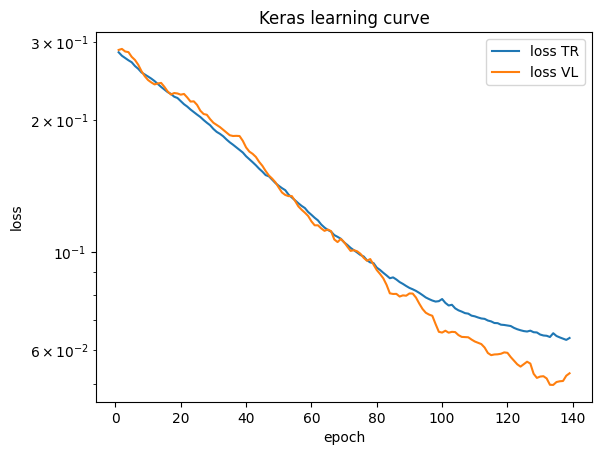

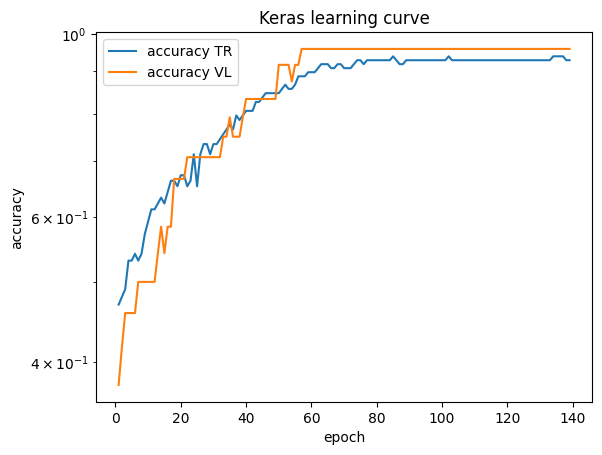

In [14]:
def keras_network(n_splits = 5, epochs = 140):
    logger.info("Initializing Keras...")

    encoder = OneHotEncoder(sparse_output=False) 

    # Getting the path to the file
    data_path_train = abs_path('monks-3.train', 'data')
    data_path_test = abs_path('monks-3.test', 'data')   

    # Reading and splitting the data
    X_train, y_train = read_split_data(data_path_train)
    X_train = encoder.fit_transform(X_train)

    X_test, y_test = read_split_data(data_path_test)
    X_test = encoder.transform(X_test)

    # Defining of the k-folding
    folds = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Model selection or manual adjustments
    logger.info("Choosing hyperparameters with a GridSearch")
    params = model_selection(X_train, y_train, n_splits=n_splits, epochs=epochs)
    print(params)
    logger.info("Grid search finished")

    # Creation of the model
    model = create_nn(input_shape = X_train.shape[1],
        eta = params["model__eta"],
        alpha = params["model__alpha"],
        lmb = params["model__lmb"],
        summary = True)

    prediction_model = create_nn(input_shape = X_train.shape[1],
        eta = params["model__eta"],
        alpha = params["model__alpha"],
        lmb = params["model__lmb"],
        summary = True)

    initial_weights = model.get_weights()

    best_model = None
    history = None
    mse_scores = []
    mse_best = float('inf')

    # Convert y_train to numpy array
    y_train = np.array(y_train, dtype=np.float32)
    print("SHAPES before split:", X_train.shape, y_train.shape)

    for train_index, val_index in folds.split(X_train, y_train):
        x_train = X_train[train_index]
        x_val = X_train[val_index]
        y_train_fold = y_train[train_index]
        y_val_fold = y_train[val_index]

        model.set_weights(initial_weights)
        fit = model.fit(x_train, y_train_fold, epochs=epochs,
                       validation_data=(x_val, y_val_fold), verbose=0)

        y_val_pred = model.predict(x_val)
        mse = mean_squared_error(y_val_fold, y_val_pred)
        mse_scores.append(mse)

        if mse < mse_best:
            mse_best = mse
            best_model = model
            history = fit

    tr_loss = history.history['loss']
    val_loss = history.history['val_loss']

    tr_accuracy = history.history['accuracy']
    val_accuracy = history.history['accuracy']

    prediction_model.set_weights(initial_weights)
    fit = prediction_model.fit(X_train, y_train, epochs=epochs, verbose=0)

    # Predicting on test set
    y_pred, test_loss = predict(model=prediction_model, 
                                                         X_test=X_test, 
                                                         y_test=y_test)
    
    y_test = y_test.astype(int)
    y_pred = (y_pred > 0.5).astype(int)

    accuracy_metric = metrics.Accuracy()
    accuracy_metric.update_state(y_test, y_pred)
    test_accuracy = accuracy_metric.result().numpy()

    # Printing the losses and accuracy 
    print("TR loss (best-performing fold): ", tr_loss[-1])
    print("TR accuracy (best-performing fold): ", tr_accuracy[-1])
    
    print("VL loss (best-performing fold): ", val_loss[-1])   
    print("VL accuracy (best-performing fold): ", val_accuracy[-1])

    print("TS loss (training on both TR and VL): ", tf.reduce_mean(test_loss).numpy())
    print("TS accuracy (training on both TR and VL): ", tf.reduce_mean(test_accuracy).numpy())

    # Classification report on test set
    print("\nDetailed Classification Report:")
    print(classification_report(y_test, y_pred))

    logger.info("Computation with Keras successfully ended!")

    plot_learning_curve(history_dic=history.history, end_epoch=epochs, savefig=False)

if __name__ == '__main__':
    keras_network()